In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# Imports

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from lightgbm import LGBMClassifier
import xgboost as xgb
import scipy.stats as stats

# Loading Data

In [3]:
# Reading both Test and Train data
df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
X_test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

# Exploratory Data Analysis

In [4]:
# Performed EDA on Local machine to see all the values. 
# Due to the Large number of features available, Didn't try to draw graphs as it would be difficult to interpret
# Used the Number of Values and correlation alone 

# Checking for missing values
missing_values = df.isnull().sum() 
print("Missing values in each column:\n", missing_values)

# Checking for data types of each column
data_types = df.dtypes
print("\nData types of each column:\n", data_types)

# Statistics of the dataset
basic_stats = df.describe()
print("\nBasic statistics of the dataset:\n", basic_stats)

Missing values in each column:
 MachineID             0
ProductName           0
EngineVersion         0
AppVersion            0
SignatureVersion      0
                   ... 
IsGamer             559
RegionIdentifier    559
DateAS                0
DateOS               24
target                0
Length: 76, dtype: int64

Data types of each column:
 MachineID            object
ProductName          object
EngineVersion        object
AppVersion           object
SignatureVersion     object
                     ...   
IsGamer             float64
RegionIdentifier    float64
DateAS               object
DateOS               object
target                int64
Length: 76, dtype: object

Basic statistics of the dataset:
        IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min      

Category counts for column: MachineID
MachineID
8e0523438a5ca48323f50b2c47f6d31a    2
0ca2c7ebe3921b5e74d8a030646ee9c2    2
43628a7db99daf5bf8ca8a3f36058ea4    2
bb11a6869fb4ec76797e97ae3006c833    2
a5f52a788ea2e509572369585ddd05c9    2
                                   ..
f0876e7b384ccc798a875aef1699916f    1
44e0d76ce920cf8a688df7feb6871ff9    1
a7a770ecb9902a3cddf504bd0c5653f5    1
ae184124b12bea48314e33a60e1b0592    1
ad9c385b53f2ca788933a39603b84eda    1
Name: count, Length: 99835, dtype: int64


Category counts for column: ProductName
ProductName
win8defender    99771
mse               229
Name: count, dtype: int64


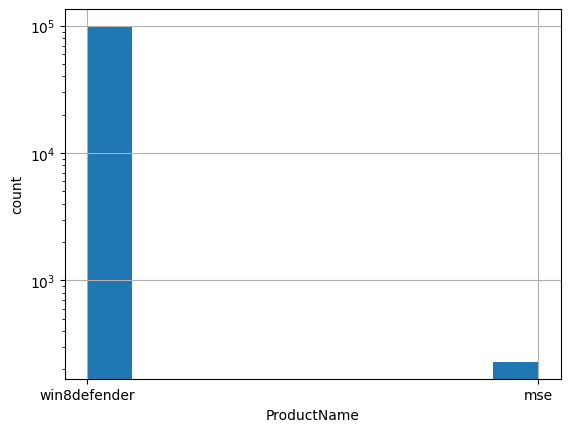



Category counts for column: EngineVersion
EngineVersion
1.1.15200.1    45219
1.1.15100.1    44017
1.1.15000.2     3169
1.1.14901.4     2597
1.1.14800.3     1719
1.1.15300.6      650
1.1.14700.5      593
1.1.14600.4      569
1.1.14104.0      328
1.1.15300.5      255
1.1.13504.0      212
1.1.14500.5      124
1.1.14405.2       82
1.1.14306.0       56
1.1.14202.0       50
1.1.14003.0       34
1.1.13804.0       33
1.1.13903.0       28
1.1.13303.0       27
1.1.13601.0       26
1.1.13407.0       23
1.1.15000.1       22
1.1.14901.3       22
1.1.13103.0       20
1.1.14305.0       17
1.1.14700.4       16
1.1.12902.0       15
1.1.13704.0       15
1.1.13701.0       15
1.1.13202.0       14
1.1.13000.0       10
1.1.14700.3        9
1.1.14800.1        7
1.1.14500.2        3
1.1.12805.0        2
1.1.13802.0        1
1.1.13803.0        1
Name: count, dtype: int64


Category counts for column: AppVersion
AppVersion
4.18.1807.18075     62119
4.18.1806.18062     10473
4.12.16299.15        3234
4.16.1765

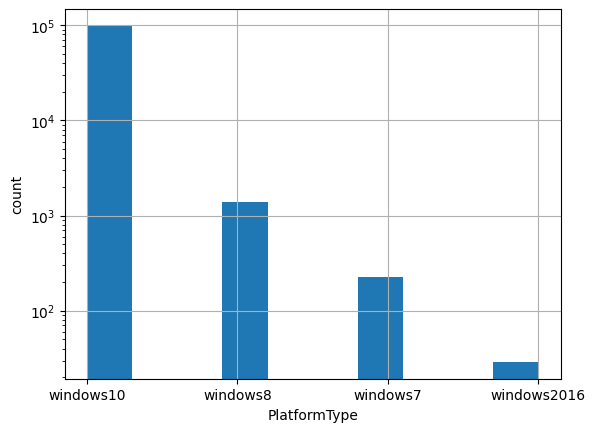



Category counts for column: Processor
Processor
x64      91262
x86       8733
arm64        5
Name: count, dtype: int64


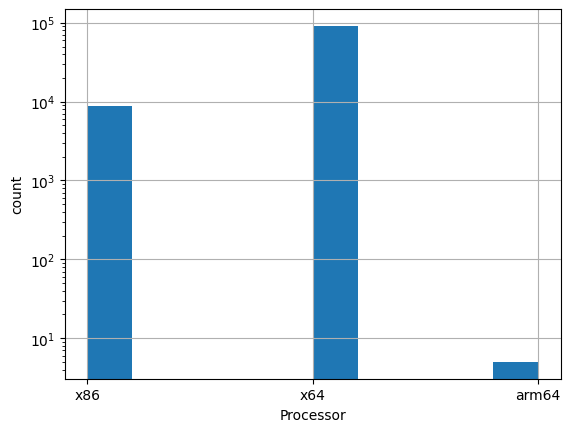



Category counts for column: OSVersion
OSVersion
10.0.0.0    98368
6.3.0.0      1401
6.1.1.0       226
10.0.1.0        2
10.0.2.0        1
10.0.3.0        1
10.0.4.0        1
Name: count, dtype: int64


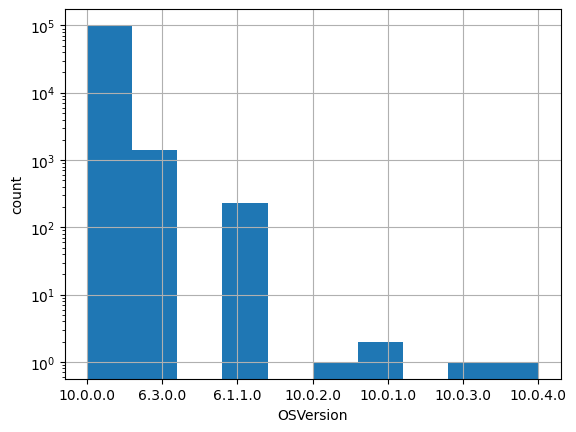



Category counts for column: OsPlatformSubRelease
OsPlatformSubRelease
rs4           45837
rs3           29632
rs2            8376
rs1            7378
th2            3869
th1            3108
windows8.1     1401
windows7        226
prers5          173
Name: count, dtype: int64


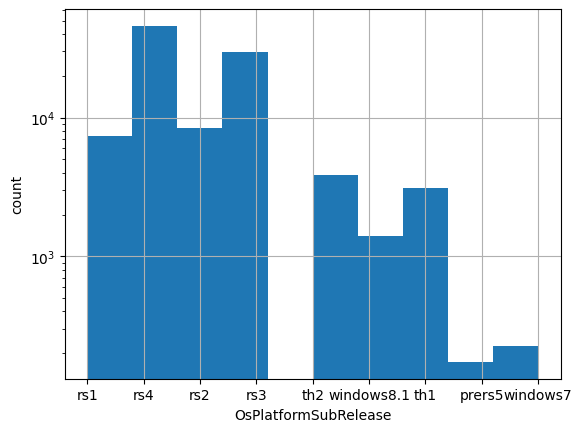



Category counts for column: OSBuildLab
OSBuildLab
17134.1.amd64fre.rs4_release.180410-1804                 42964
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    15157
16299.15.amd64fre.rs3_release.170928-1534                11108
15063.0.amd64fre.rs2_release.170317-1834                  7757
17134.1.x86fre.rs4_release.180410-1804                    2869
                                                         ...  
7601.23072.amd64fre.win7sp1_ldr.150525-0604                  1
10240.16724.x86fre.th1_st1.160222-1812                       1
7601.18700.amd64fre.win7sp1_gdr.141211-1742                  1
9600.17476.amd64fre.winblue_r5.141029-1500                   1
9600.18258.amd64fre.winblue_ltsb.160303-0600                 1
Name: count, Length: 281, dtype: int64


Category counts for column: SKUEditionName
SKUEditionName
Home               62863
Pro                35753
Education            503
Enterprise           388
Enterprise LTSB      250
Invalid              176
Cloud 

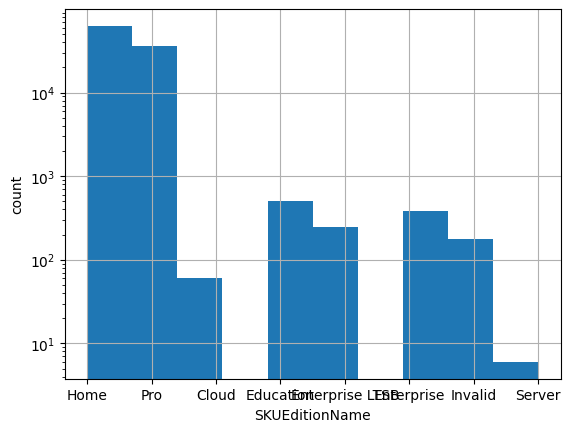



Category counts for column: MDC2FormFactor
MDC2FormFactor
Notebook        64547
Desktop         21612
Convertible      4807
Detachable       3510
AllInOne         3147
PCOther          1274
LargeTablet       706
SmallTablet       351
SmallServer        32
MediumServer       10
LargeServer         4
Name: count, dtype: int64


Category counts for column: DeviceFamily
DeviceFamily
Windows.Desktop    99971
Windows.Server        29
Name: count, dtype: int64


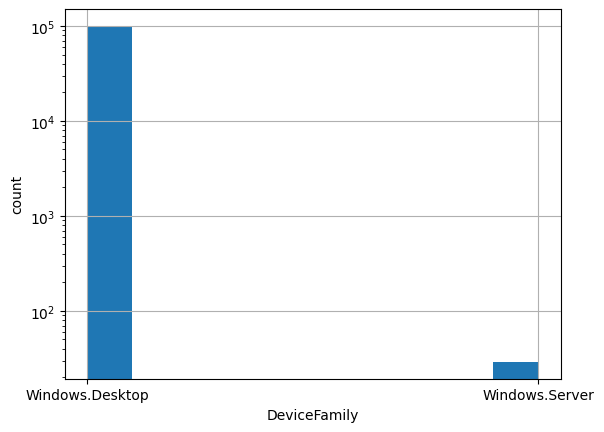



Category counts for column: PrimaryDiskType
PrimaryDiskType
HDD            66202
SSD            27895
UNKNOWN         3105
Unspecified     2775
Name: count, dtype: int64


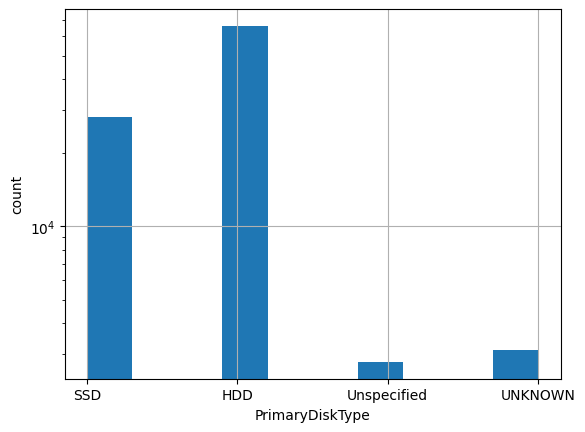



Category counts for column: ChassisType
ChassisType
Notebook               59459
Desktop                20818
Laptop                  7811
Portable                4126
AllinOne                2269
Convertible              966
MiniTower                952
Detachable               611
LowProfileDesktop        559
Other                    535
HandHeld                 526
UNKNOWN                  454
SpaceSaving              324
Tablet                   163
Tower                    129
MainServerChassis        111
Unknown                   59
LunchBox                  39
MiniPC                    34
RackMountChassis          17
BusExpansionChassis       13
SubNotebook               11
0                          4
30                         4
CompactPCI                 1
SubChassis                 1
MultisystemChassis         1
35                         1
Name: count, dtype: int64


Category counts for column: PowerPlatformRole
PowerPlatformRole
Mobile               69874
Desktop        

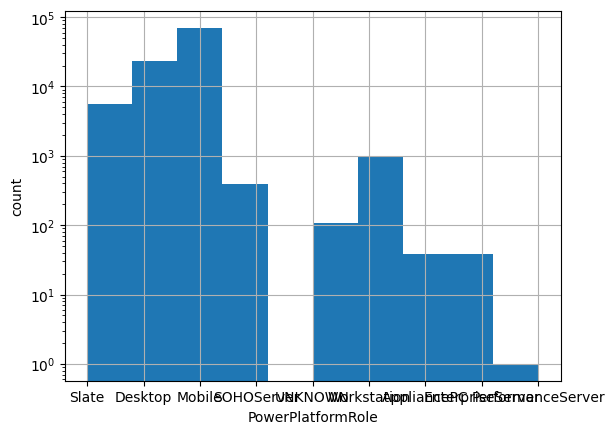



Category counts for column: NumericOSVersion
NumericOSVersion
10.0.17134.228      17069
10.0.17134.165      11212
10.0.16299.431       6635
10.0.17134.285       5255
10.0.16299.547       4221
                    ...  
10.0.14393.1378         1
10.0.10240.16397        1
10.0.15063.1154         1
10.0.17723.1000         1
10.0.17686.1003         1
Name: count, Length: 221, dtype: int64


Category counts for column: OSArchitecture
OSArchitecture
amd64    91281
x86       8714
arm64        5
Name: count, dtype: int64


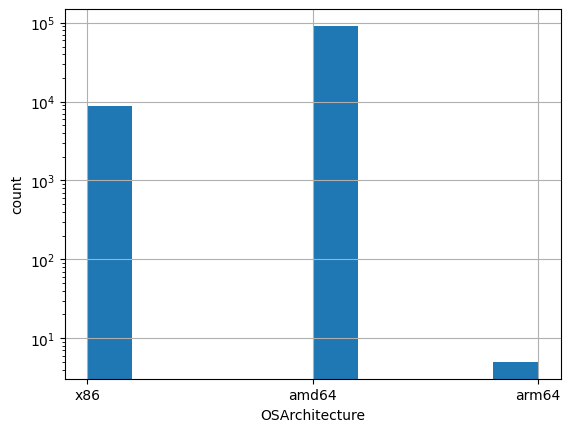



Category counts for column: OSBranch
OSBranch
rs4_release                  46909
rs3_release_svc_escrow       14518
rs3_release                  14343
rs2_release                   8527
rs1_release                   7780
th2_release_sec               2912
th1_st1                       2298
th2_release                   1632
th1                            827
rs5_release                    145
rs3_release_svc_escrow_im       78
rs_prerelease_flt               26
rs_prerelease                    5
Name: count, dtype: int64


Category counts for column: OSEdition
OSEdition
Core                       39275
Professional               34602
CoreSingleLanguage         22006
CoreCountrySpecific         1823
ProfessionalEducation        704
Education                    495
Enterprise                   391
ProfessionalN                289
EnterpriseS                  238
Cloud                         67
CoreN                         49
ServerStandard                21
EnterpriseSN             

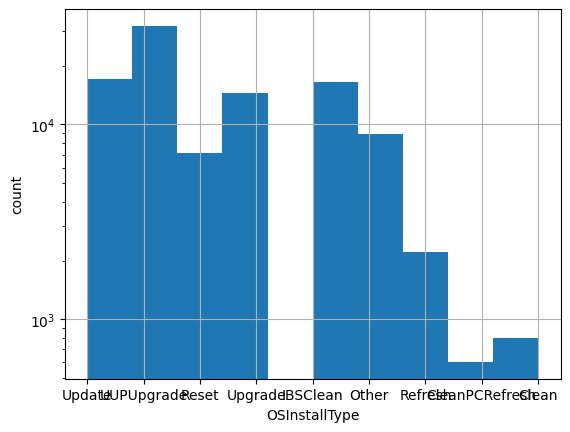



Category counts for column: AutoUpdateOptionsName
AutoUpdateOptionsName
FullAuto                                 45154
UNKNOWN                                  26299
Notify                                   23746
AutoInstallAndRebootAtMaintenanceTime     4444
Off                                        328
DownloadNotify                              29
Name: count, dtype: int64


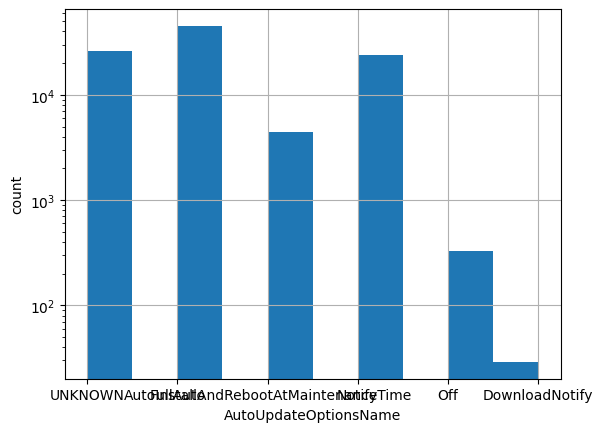



Category counts for column: OSGenuineState
OSGenuineState
IS_GENUINE         89860
INVALID_LICENSE     8442
OFFLINE             1583
UNKNOWN              115
Name: count, dtype: int64


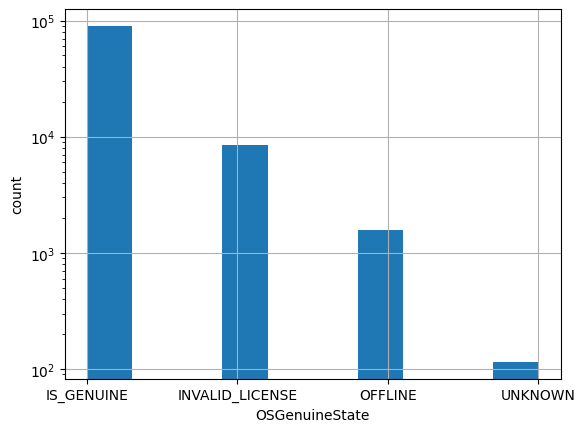



Category counts for column: LicenseActivationChannel
LicenseActivationChannel
Retail            52195
OEM:DM            39178
Volume:GVLK        4643
OEM:NONSLP         3884
Volume:MAK           94
Retail:TB:Eval        6
Name: count, dtype: int64


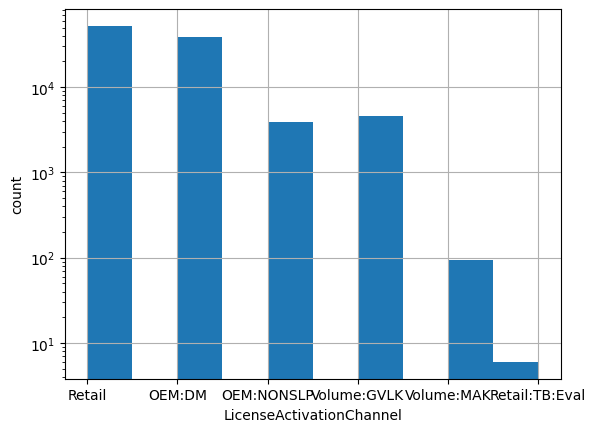



Category counts for column: FlightRing
FlightRing
Retail      94153
NOT_SET      3025
Unknown      2489
RP            123
WIF            90
WIS            84
Disabled       36
Name: count, dtype: int64


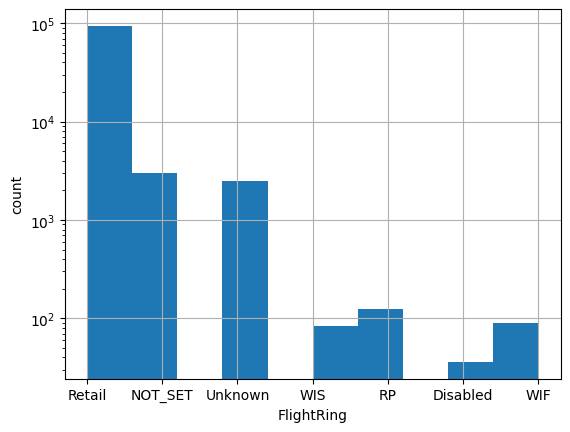



Category counts for column: DateAS
DateAS
2018-08-15 06:29:00    1274
2018-09-14 00:32:00    1272
2018-07-26 06:54:00    1068
2018-09-04 22:13:00    1045
2018-08-22 05:11:00     997
                       ... 
2017-03-29 21:29:00       1
2018-04-22 00:27:00       1
2017-09-16 13:19:00       1
2018-01-06 13:53:00       1
2017-09-28 08:53:00       1
Name: count, Length: 2695, dtype: int64


Category counts for column: DateOS
DateOS
2018-08-14    20905
2018-07-10    16719
2018-05-08     8156
2018-04-10     6946
2018-06-12     6442
              ...  
2015-08-14        2
2017-11-02        2
2015-11-18        1
2016-06-02        1
2017-07-18        1
Name: count, Length: 112, dtype: int64




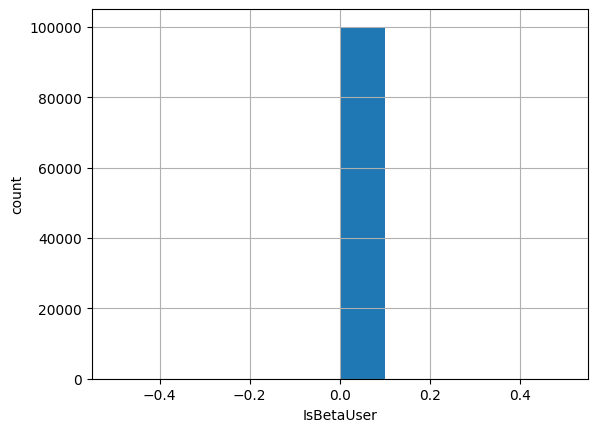

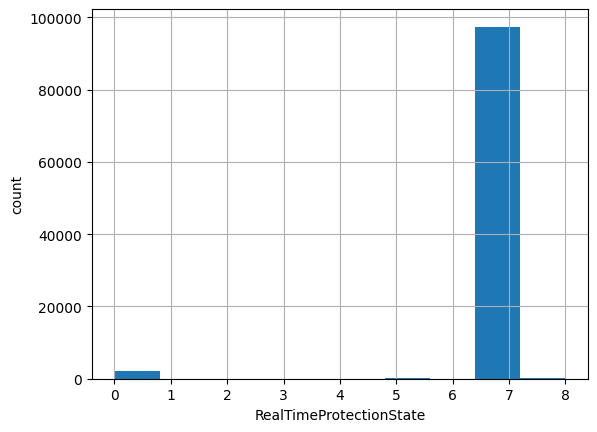

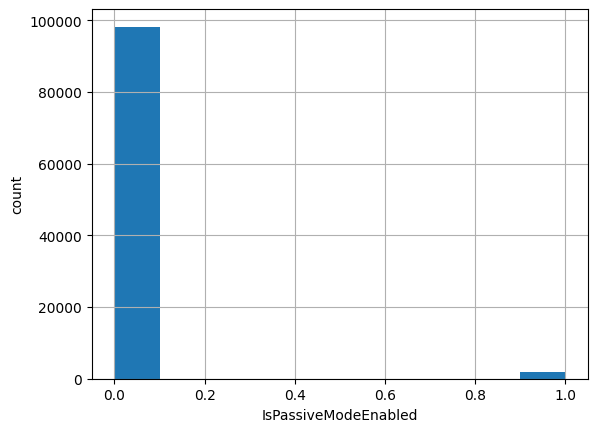

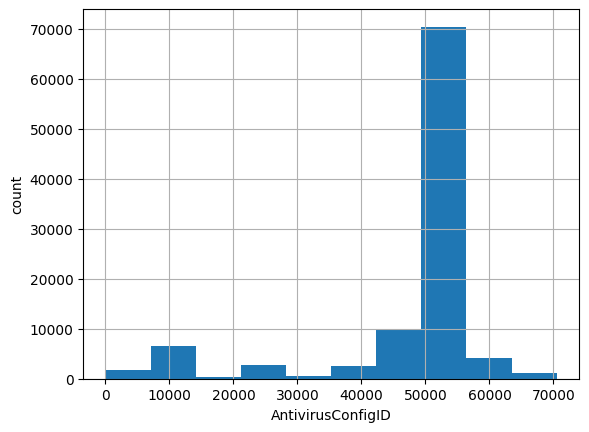

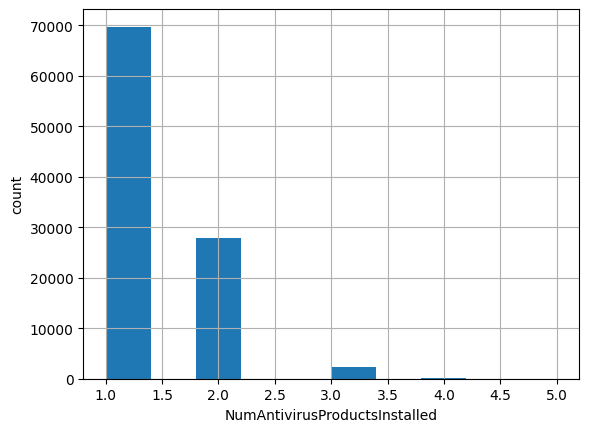

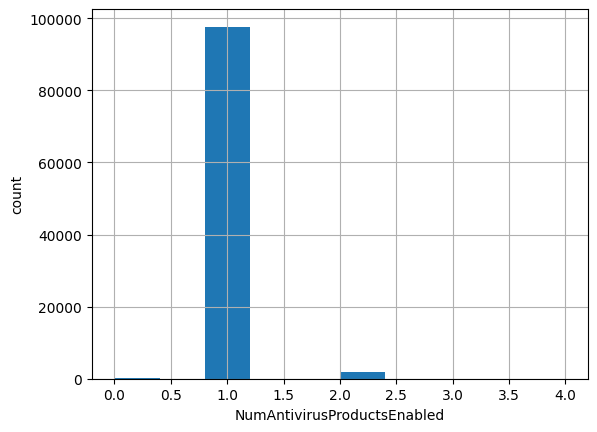

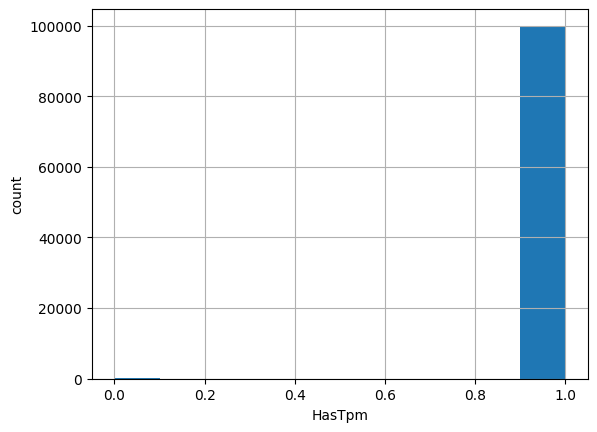

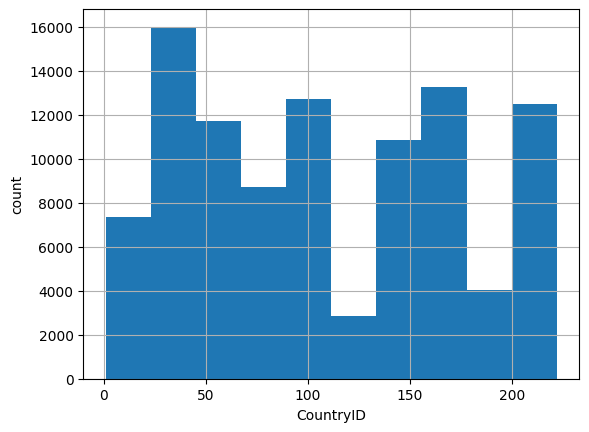

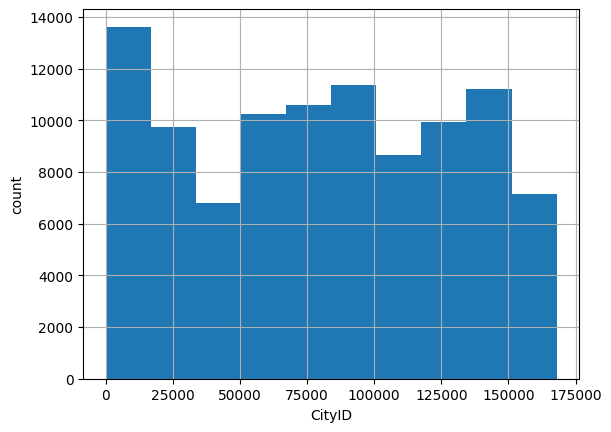

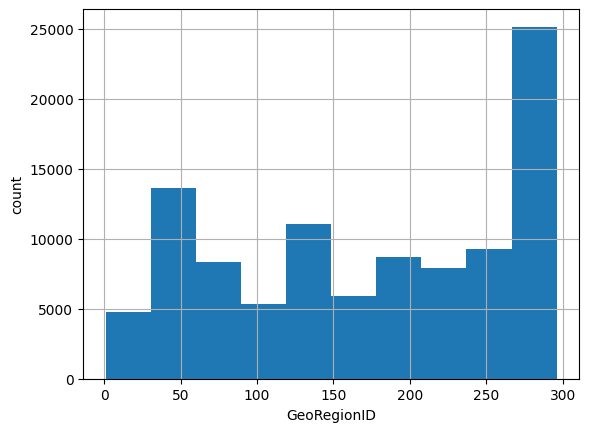

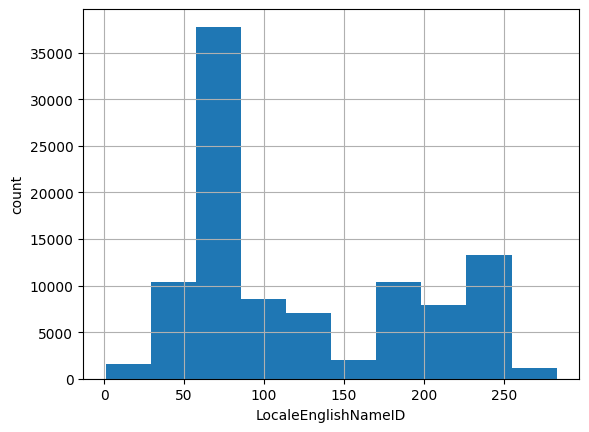

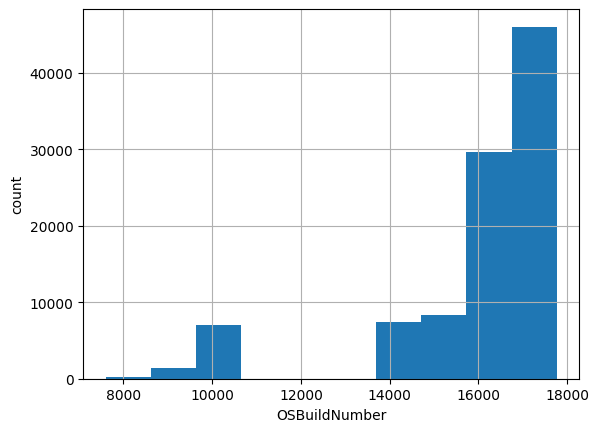

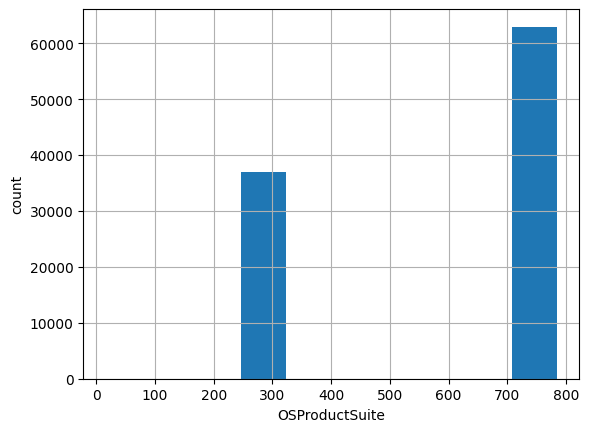

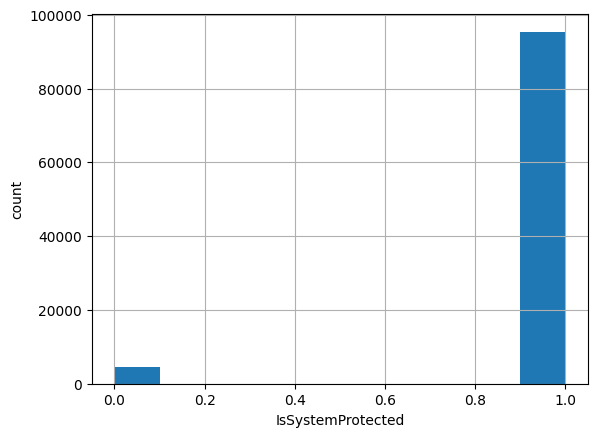

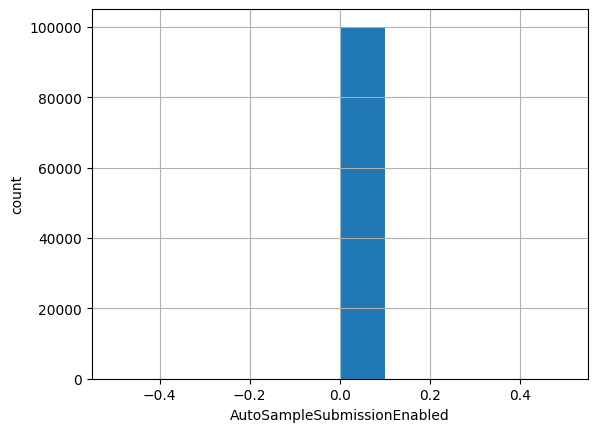

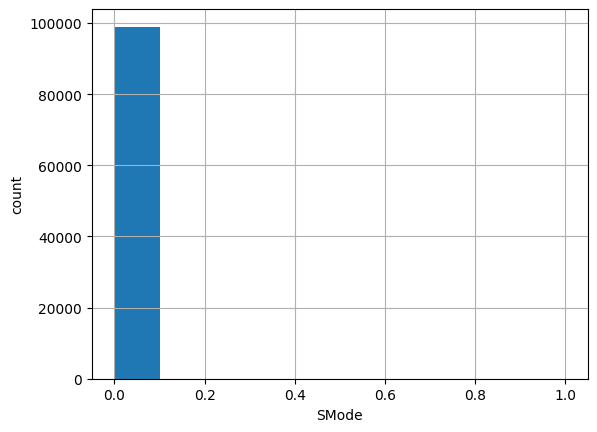

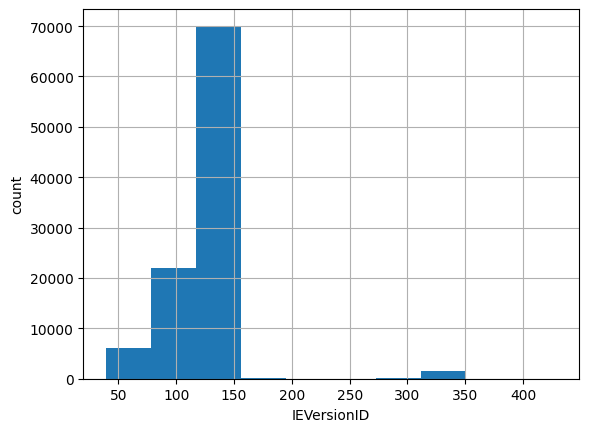

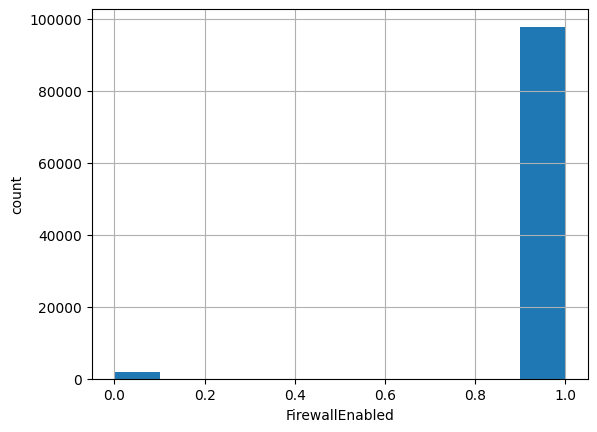

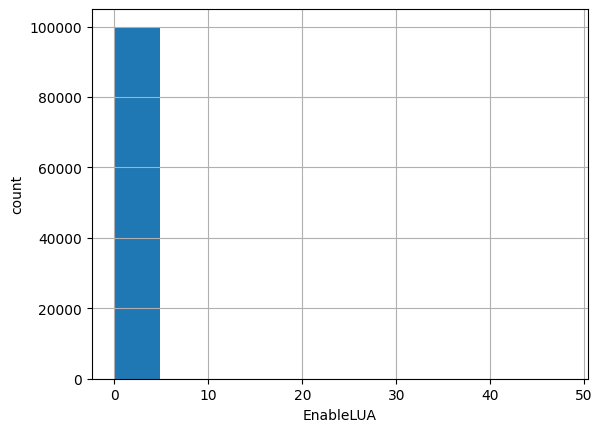

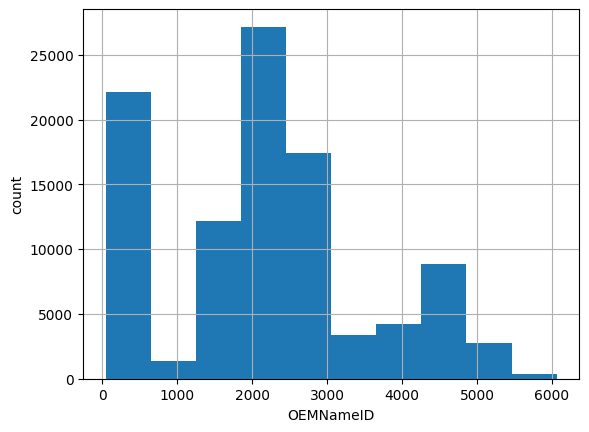

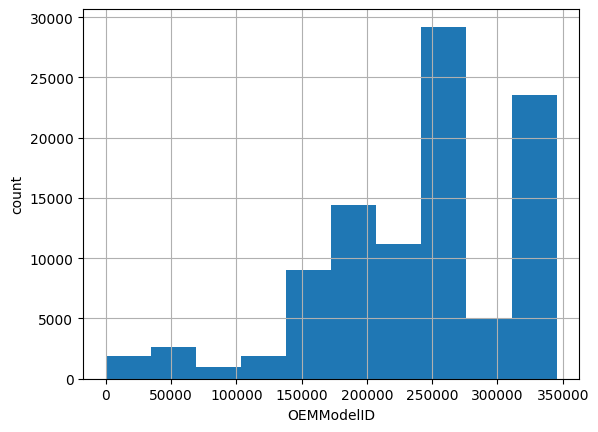

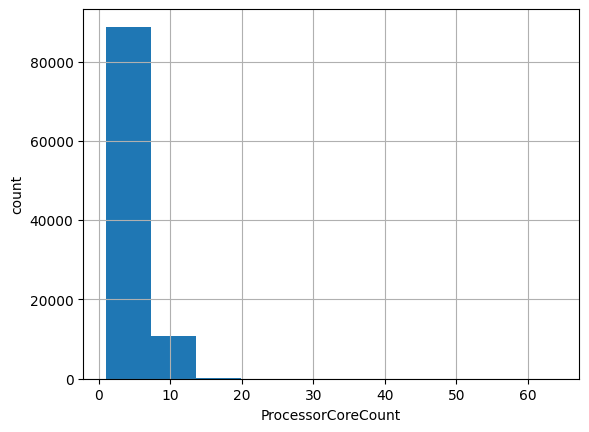

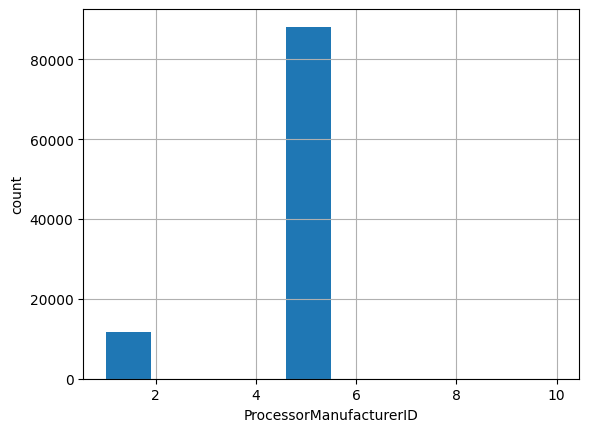

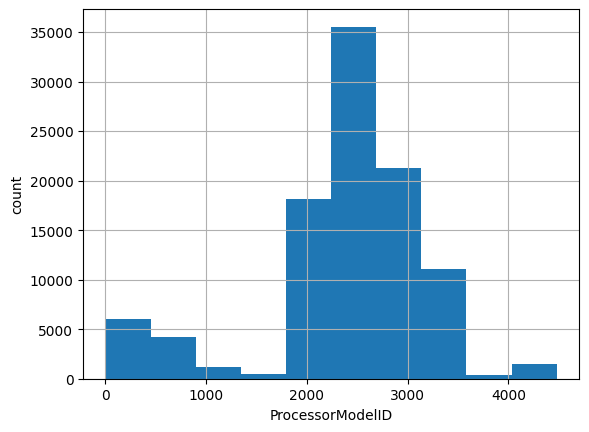

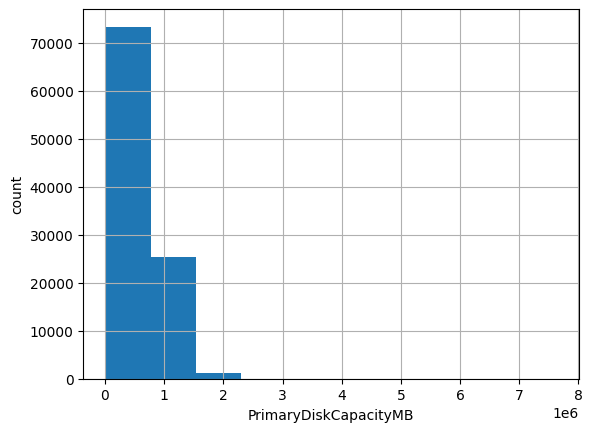

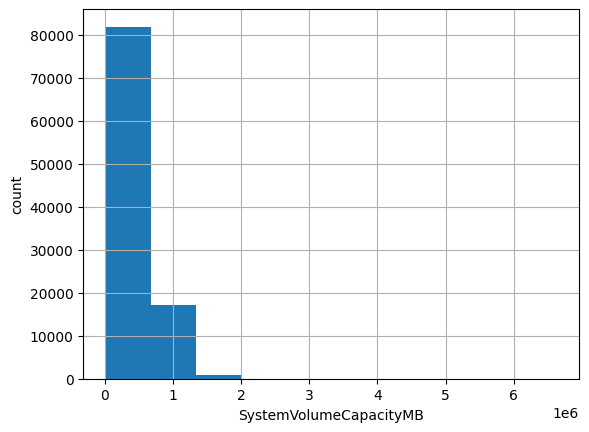

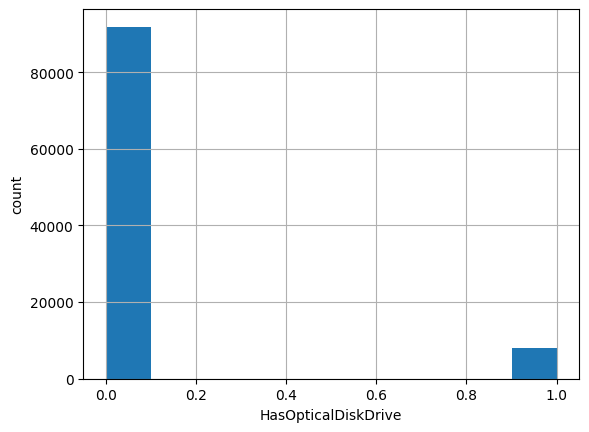

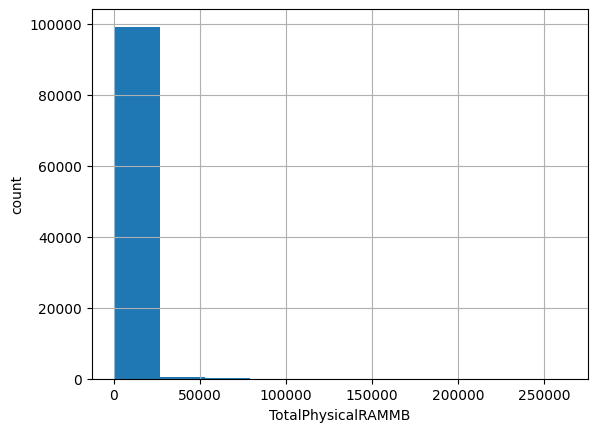

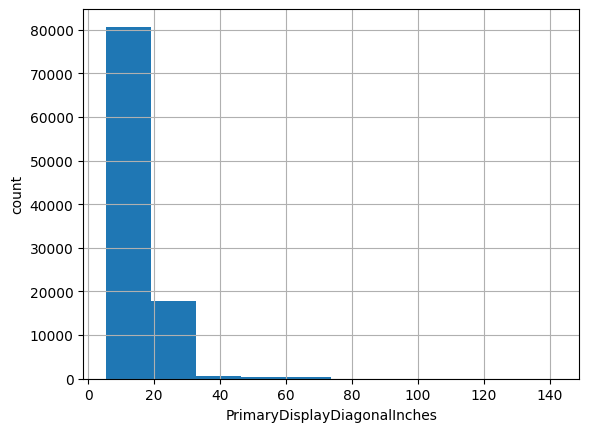

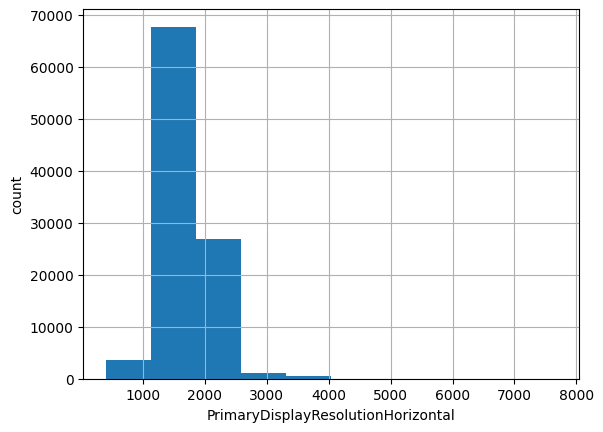

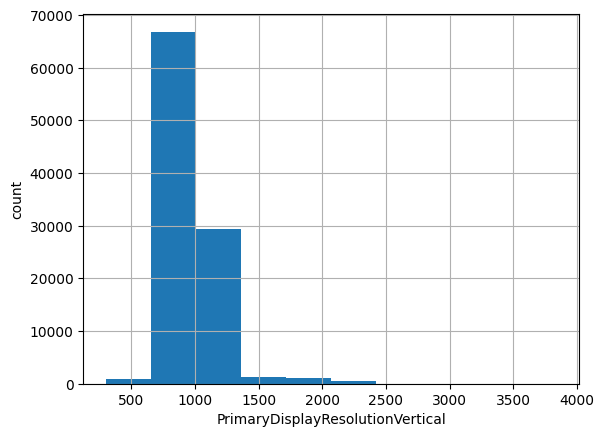

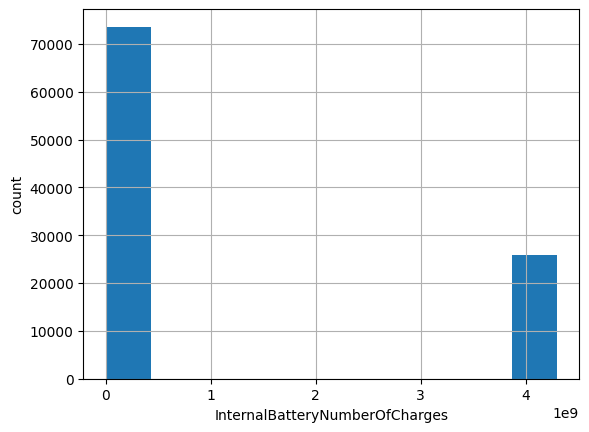

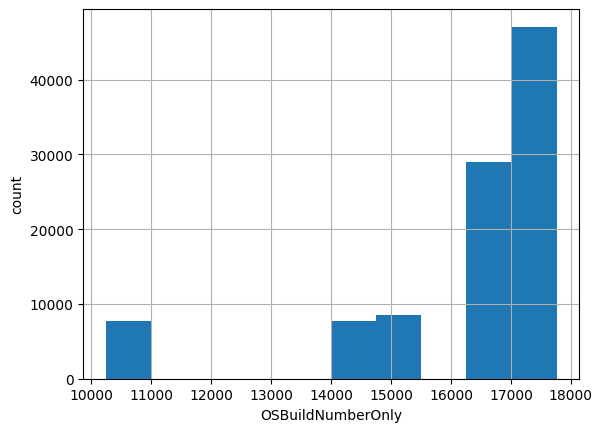

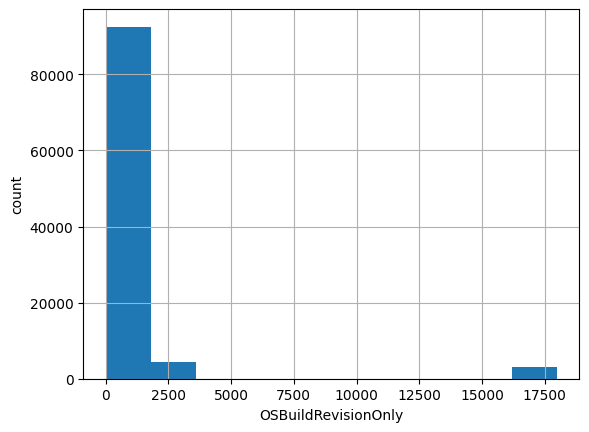

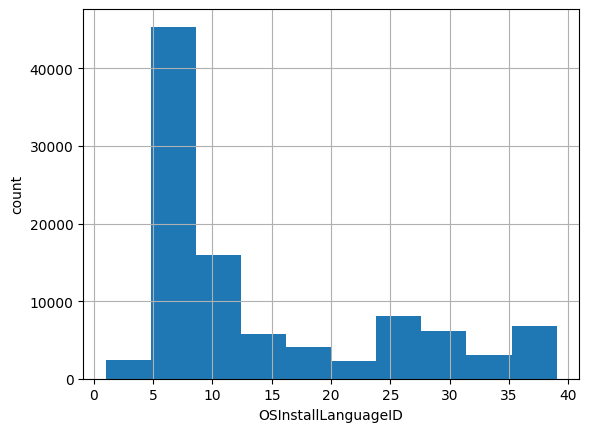

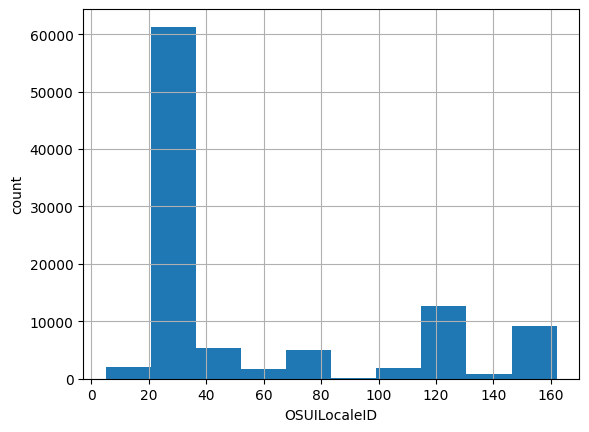

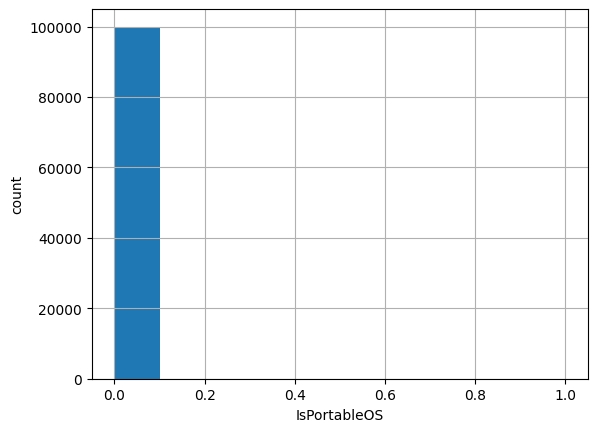

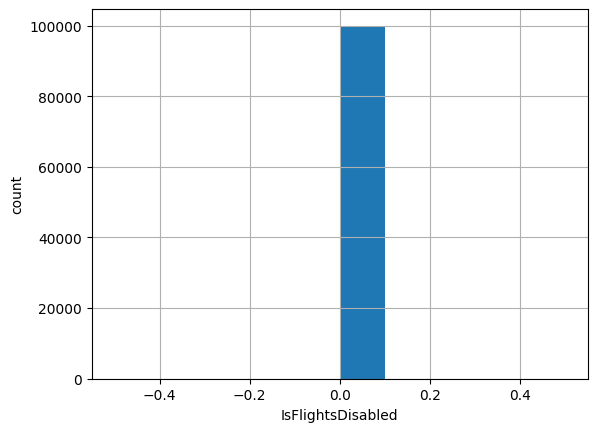

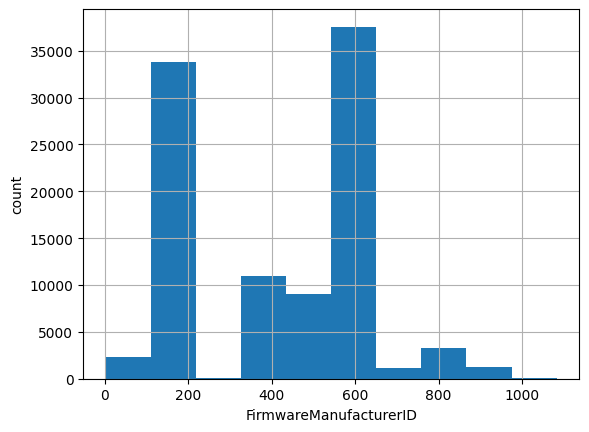

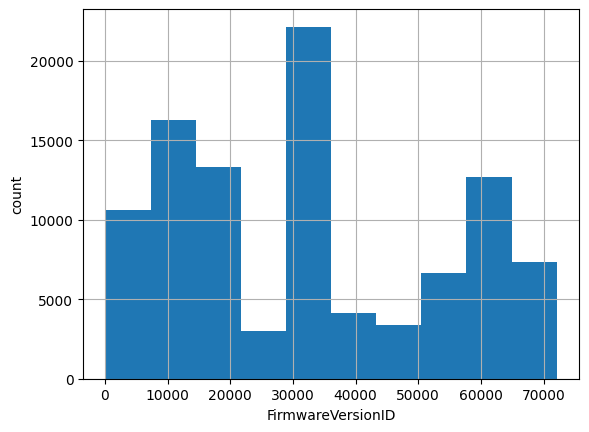

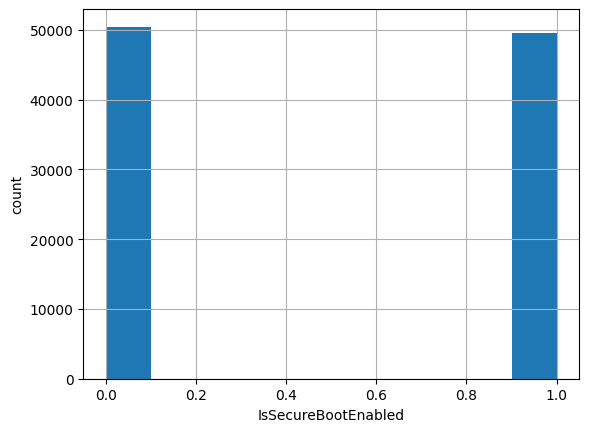

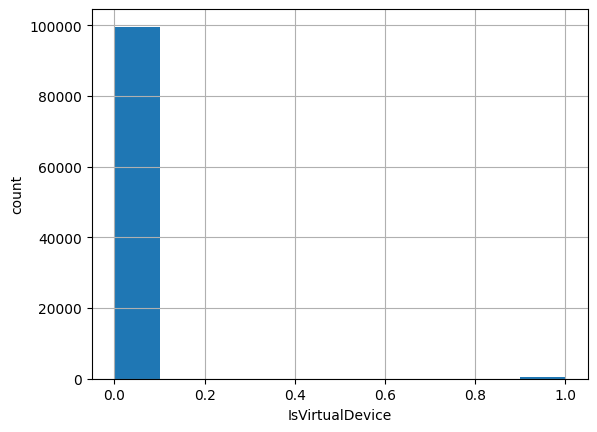

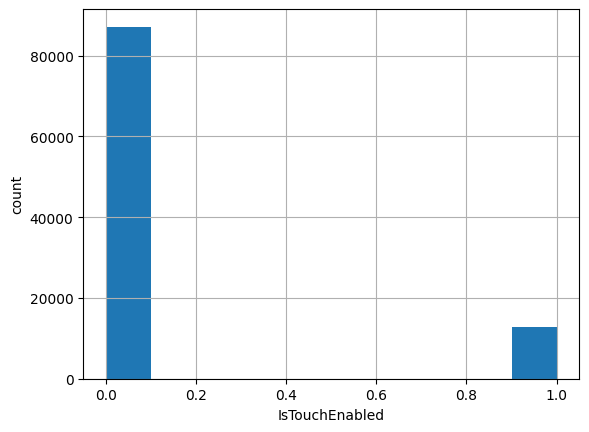

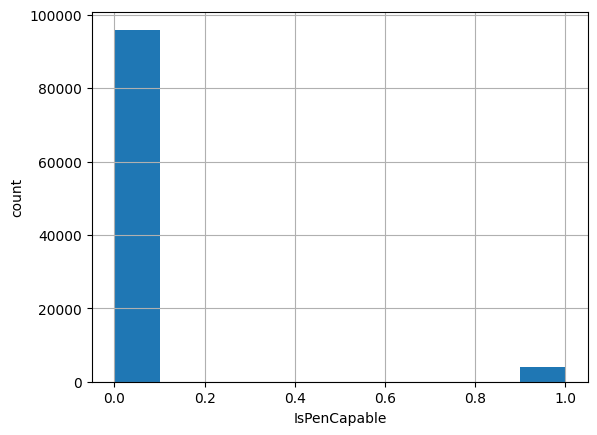

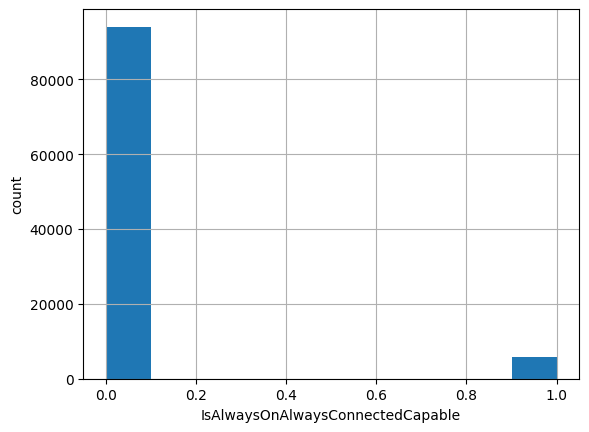

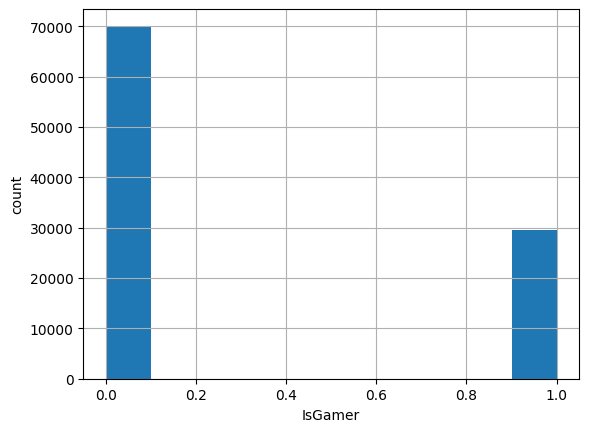

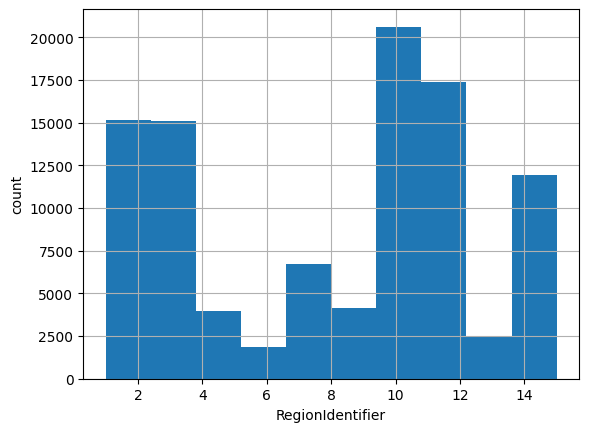

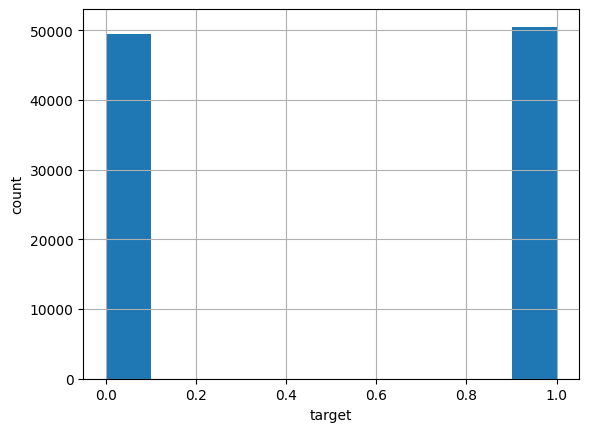

In [5]:
# Checking for Unique Values to see Redundant
# Full output was visible in Local Machine
#Getting all categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

#Checking all value counts of Categorical columns
for column in categorical_columns:
    print(f"Category counts for column: {column}")
    print(df[column].value_counts())
    if (len(df[column].value_counts())<10):
        df[column].hist(log=True)
        plt.xlabel(column)
        plt.ylabel("count")
        plt.show()
    print("\n")

numeric_columns = df.select_dtypes(include=['number']).columns
for column in numeric_columns:
    df[column].hist()
    plt.xlabel(column)
    plt.ylabel("count")
    plt.show()

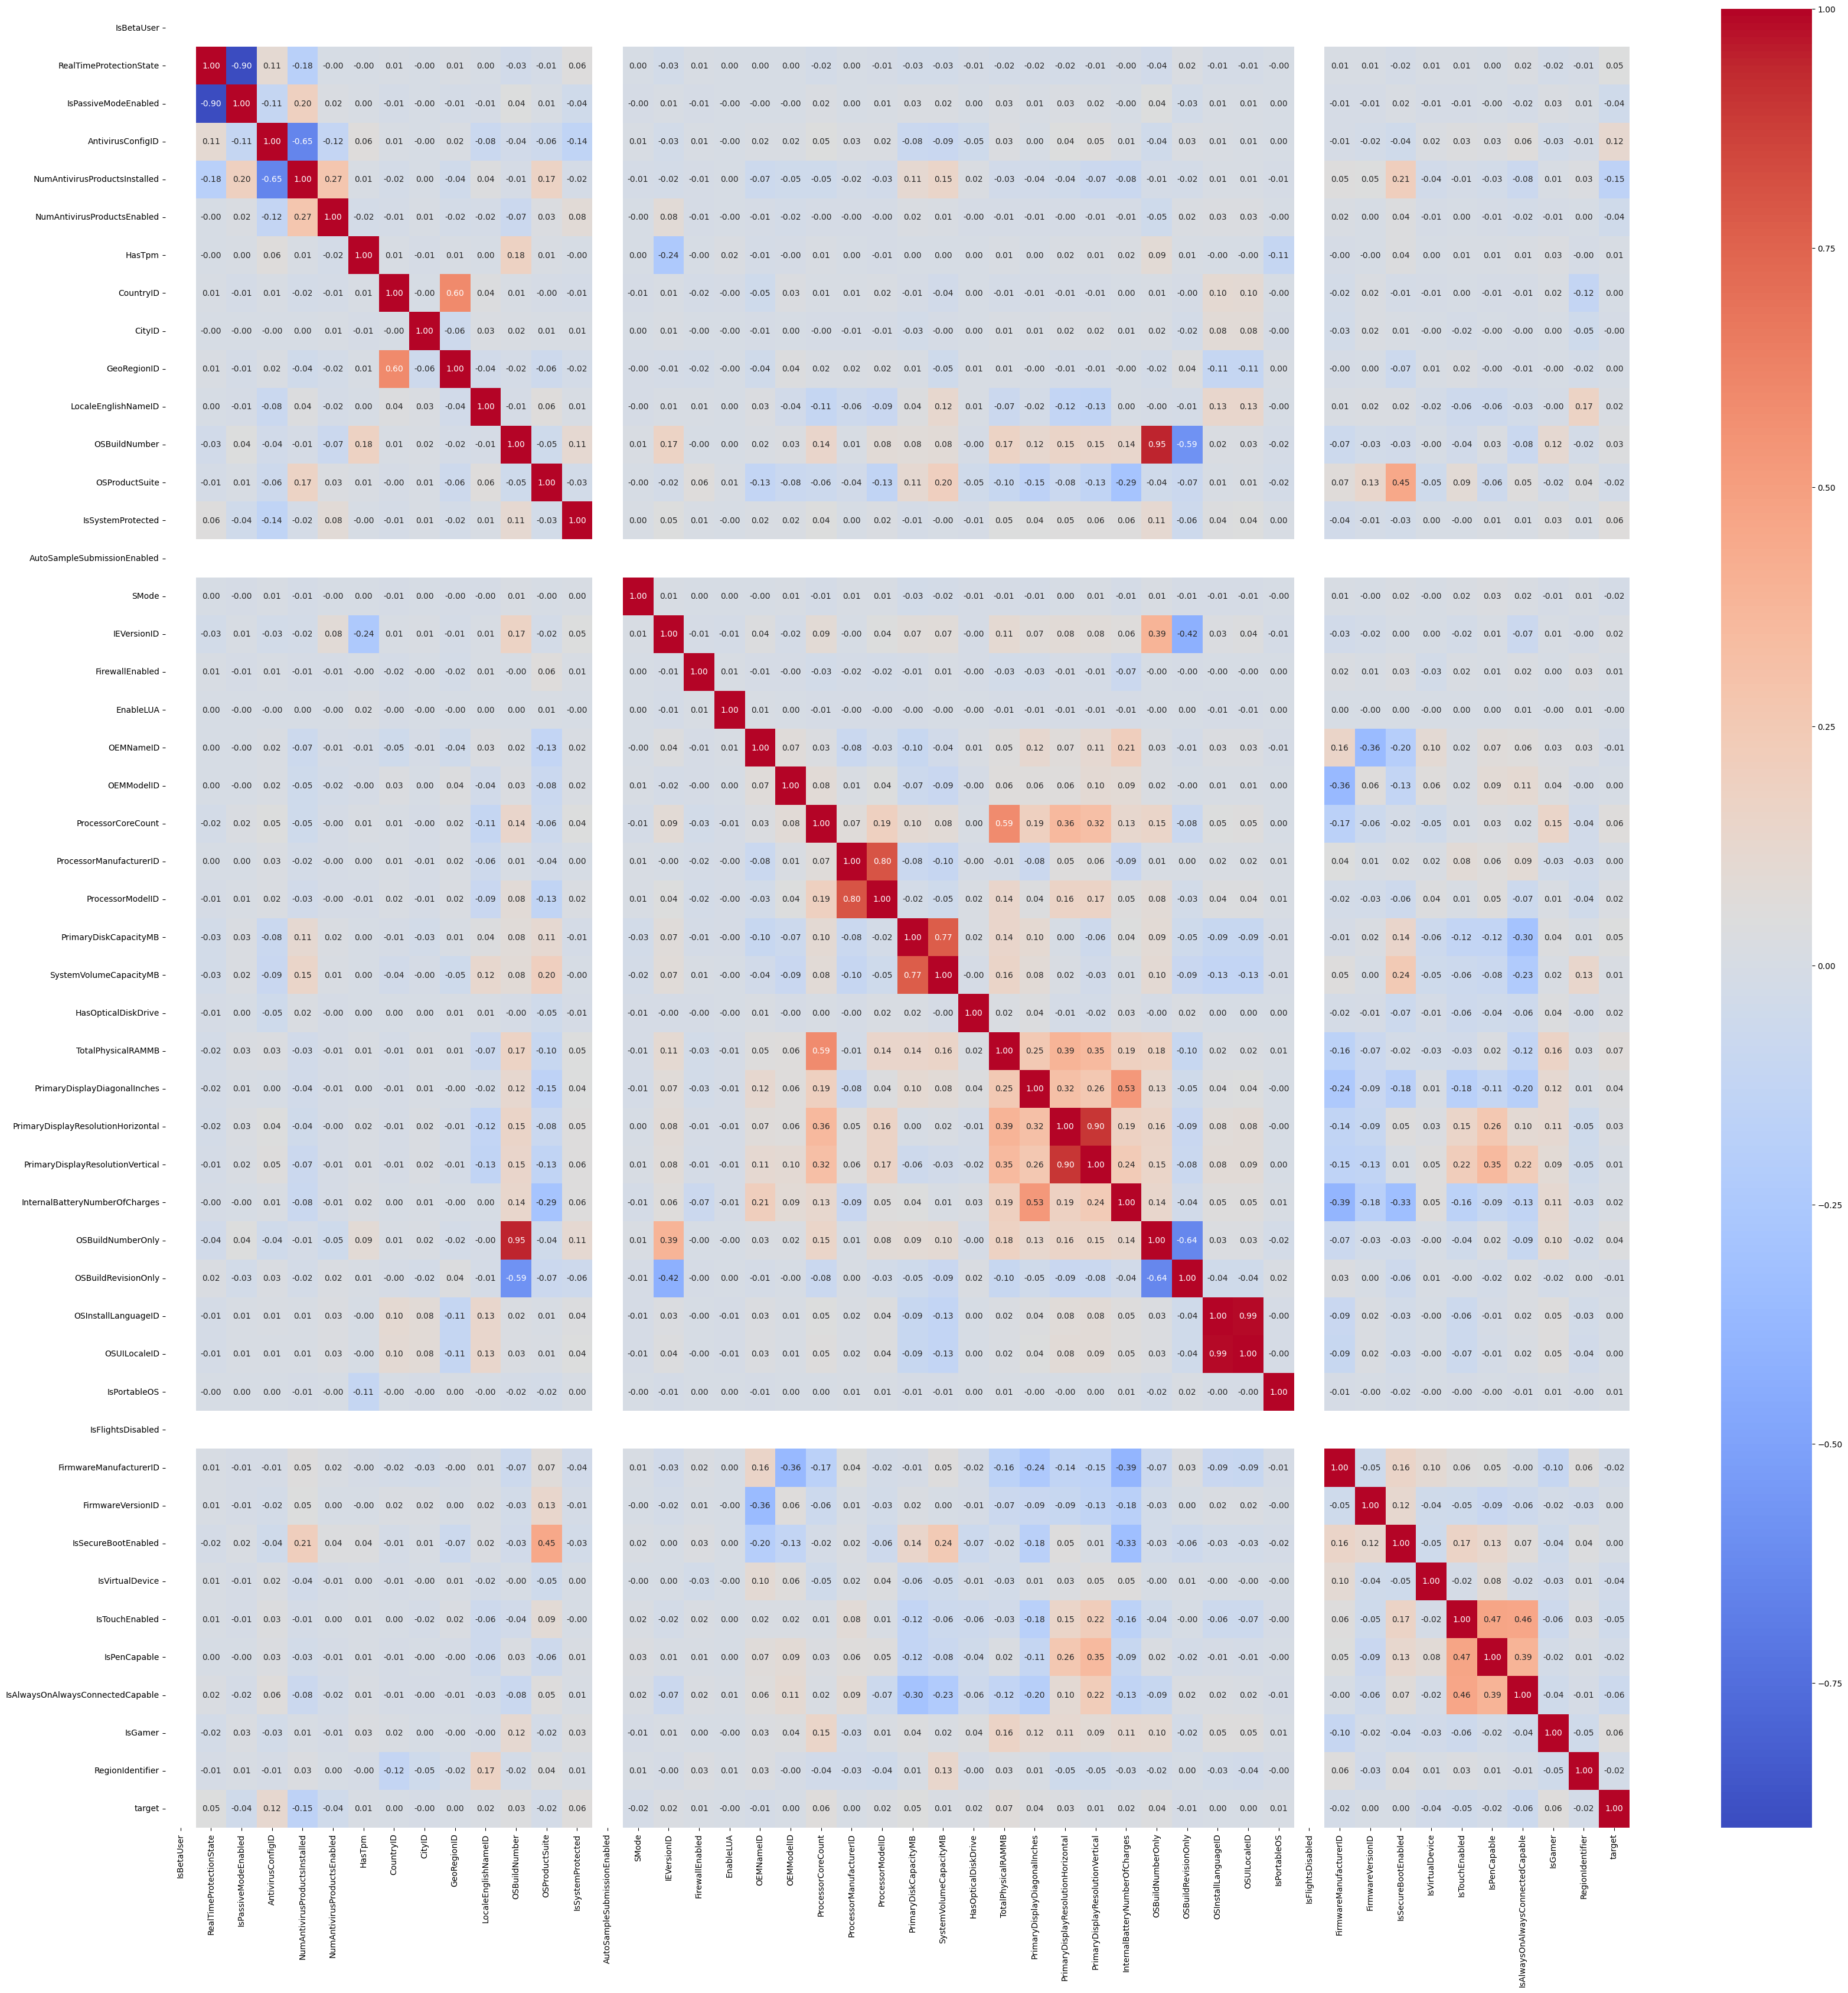

In [6]:
# Correlation Heat map To visualize the Correlation
plt.figure(figsize=(40, 40))  
sns.heatmap(df.select_dtypes(include = ["number"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.show()

# Some insights
# There are columns like isBetaUser, AutoSampleSubmissionEnabled, isFlightsDisabled which are completly Redundant
# Columns such as RealTimeProtection State, IsPassiveModeEnabled are highly Correlated
# Some Columns are just Aggregates of Other columns such as OSBuildNumberOnly which is just part of OSBuildNumber

# Preprocessing

In [7]:
# Custom Preprocessing
# This conversion helped only in some cases
def version_to_number(version_string):
    """
    Convert version string like '10.2.34.20' into a numerical representation.
    Each segment is treated as a separate number and concatenated.
    E.g., '10.2.34.20' -> 1023420
    """
    try:
        return int(''.join(segment for segment in version_string.split('.')))
    except:
        return version_string

def date_to_number(date_string):
    """
    Convert a date string like 'YYYY-MM-DD HH:MM:SS' into epoch time.
    E.g., '2018-08-15 06:29:00' -> 1534313340
    """
    try:
        return int(datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S").timestamp())
    except :
        try: 
            return int(datetime.strptime(date_string, "%Y-%m-%d").timestamp())
        except:
            return date_string
        return date_string 
        
#convert to numbers, similar to label encoding       
df["EngineVersion"] = df["EngineVersion"].apply(version_to_number)
X_test_df["EngineVersion"] = X_test_df["EngineVersion"].apply(version_to_number)
df["AppVersion"] = df["AppVersion"].apply(version_to_number)
X_test_df["AppVersion"] = X_test_df["AppVersion"].apply(version_to_number)
df["SignatureVersion"] = df["SignatureVersion"].apply(version_to_number)
X_test_df["SignatureVersion"] = X_test_df["SignatureVersion"].apply(version_to_number)
df["OSVersion"] = df["OSVersion"].apply(version_to_number)
X_test_df["OSVersion"] = X_test_df["OSVersion"].apply(version_to_number)
df["NumericOSVersion"] = df["NumericOSVersion"].apply(version_to_number)
X_test_df["NumericOSVersion"] = X_test_df["NumericOSVersion"].apply(version_to_number)


# Below Feature Engineering made the model worse

# df["DateAS"] = df["DateAS"].apply(date_to_number)
# X_test_df["DateAS"] = X_test_df["DateAS"].apply(date_to_number)
# df["DateOS"] = df["DateOS"].apply(date_to_number)
# X_test_df["DateOS"] = X_test_df["DateOS"].apply(date_to_number)
# 'IsSecureBootEnabled' 'FirewallEnabled' 'TPMEnabled'

# df["Resolution"] = df['SystemVolumeCapacityMB'] / df['PrimaryDiskCapacityMB'] 
# X_test_df["Resolution"] = X_test_df['SystemVolumeCapacityMB'] / X_test_df['PrimaryDiskCapacityMB'] 
# df['More_Protected'] = df["DateAS"].apply(date_to_number) - df["DateOS"].apply(date_to_number)
# X_test_df['More_Protected'] = df["DateAS"].apply(date_to_number) - df["DateOS"].apply(date_to_number)

# df = df.drop(columns=["CityID","GeoRegionID"])
# X_test_df = X_test_df.drop(columns=["CityID","GeoRegionID"])

# Feature Engineering

In [8]:
# Fraction used is basically trying to encode how much of the antivirus installed is actually used
df["fraction_used"] = df.NumAntivirusProductsEnabled/df.NumAntivirusProductsInstalled
# df["fraction_used"] = df["fraction_used"].fillna(0)
X_test_df["fraction_used"] = X_test_df.NumAntivirusProductsEnabled/X_test_df.NumAntivirusProductsInstalled
# X_test_df["fraction_used"] = X_test_df["fraction_used"].fillna(0)

# 'SystemVolumeCapacityMB' 'TotalPhysicalRAMMB'

# df['Capacity'] = df['TotalPhysicalRAMMB'] / df['SystemVolumeCapacityMB']
# df['Capacity'] = df['TotalPhysicalRAMMB'].fillna(0)
# X_test_df['Capacity'] = X_test_df['TotalPhysicalRAMMB'] / X_test_df['SystemVolumeCapacityMB']
# X_test_df['Capacity'] = X_test_df['TotalPhysicalRAMMB'].fillna(0)

## Columns for OneHotEncoding,Ordinal Encoding
**Tried different Combinations and settled with this**

**Didn't drop redundant columns as it resulted in slightly worse performance**

In [9]:
ohe_columns = ["AutoUpdateOptionsName","OSSkuFriendlyName","ProductName","PlatformType","Processor","DeviceFamily","PrimaryDiskType","OSGenuineState","OSArchitecture","OsPlatformSubRelease","OSBuildLab","SKUEditionName","MDC2FormFactor","ChassisType","PowerPlatformRole","OSBranch","OSEdition", "OSInstallType","FlightRing","LicenseActivationChannel"]
columns = list(set(df.columns) - set(ohe_columns) - set(["target"]))
ordinal = ["MachineID","DateOS","DateAS"]

# Preprocessing using Pipeline

In [10]:
X_train = df.drop("target",axis=1)
y_train = df["target"]
X_test = X_test_df

ordinal_pipe = Pipeline([
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )),
]).set_output(transform='pandas')

ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        sparse_output=False,
        handle_unknown='ignore'
    ))
])

# Features reordering happened leading to slightly worse 
# performance in test, so removed ColumnTransformer
# full_pipeline = Pipeline([
#     ('preprocessor', ColumnTransformer([
#             ('ordinal', ordinal_pipe, ordinal),
#             ('one_hot', ohe_pipe, ohe_columns)
#         ], remainder='passthrough')),
    
#     ('scaler', StandardScaler())
# ]).set_output(transform='pandas')

ohe_train = ohe_pipe.fit_transform(X_train[ohe_columns])
ohe_test = ohe_pipe.transform(X_test[ohe_columns])


ohe_train_df = pd.DataFrame(ohe_train, columns=ohe_pipe.named_steps["encoder"].get_feature_names_out(ohe_columns))
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe_pipe.named_steps["encoder"].get_feature_names_out(ohe_columns))

X_train[ordinal] = ordinal_pipe.fit_transform(X_train[ordinal])
X_test[ordinal] = ordinal_pipe.transform(X_test[ordinal])

X_train = X_train.drop(ohe_columns, axis=1).join(ohe_train_df)
X_test = X_test.drop(ohe_columns, axis=1).join(ohe_test_df)

# Dropping the Na Created due to ohe, 
# Dropping lead to better results than imputing
X_train["target"] = y_train
X_train = X_train.dropna()
y_train = X_train["target"]
X_train = X_train.drop("target",axis=1)

# Tried MinMax And Max Absolute scalers
# Although better in train, Ended slightly worse in test data
# The models fit test better when the scaling is done acccording to normal assumption

# XGBoost and LightGBM can deal with NAs, Leaving things unimputed gives slightly better in Test
# Performance
# si = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
# si.fit(X_train)
# X_test = si.transform(X_test)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Parameter Tuning Using Grid Search and Random Search
## Train validation split is not done as it is taken care by CrossValidation Inbuilt in GridSearch and RandomSearch

**All Searches are commented out to make the notebook run faster** 
**Final Parameters from the Searches are used directly**


**LightGBM**

[LightGBM] [Info] Number of positive: 48969, number of negative: 47726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5405
[LightGBM] [Info] Number of data points in the train set: 96695, number of used features: 268
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Top 5 Features: ['CityID', 'MachineID', 'DateAS', 'SystemVolumeCapacityMB', 'ProcessorModelID']


0.7320130306634263

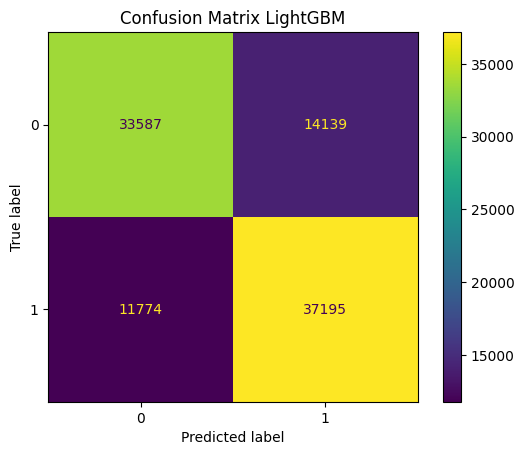

In [11]:
# param_dict = {'learning_rate': [0.1,0.01,0.3], 'max_depth': [-1,6], 'n_estimators': [100,200], 'num_leaves': [50,64,72]}

# lgbm = LGBMClassifier(random_state=0,class_weight='balanced')
# # Fit The grid Search Model
# grid_search = GridSearchCV(lgbm,param_grid=param_dict,cv=2,scoring='accuracy')
# grid_search.fit(X_train_scaled,y_train)
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# Due TO -1, Lightgbm ends up overfitting
params = {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 64}
lgbm = LGBMClassifier(**params, random_state=0, class_weight='balanced') # having Balanced is just a precaution, The dataset is balanced
lgbm.fit(X_train_scaled,y_train)


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, lgbm.predict(X_train_scaled)), display_labels=lgbm.classes_)
disp.plot(cmap="viridis")  
plt.title("Confusion Matrix LightGBM")

feature_importances = lgbm.feature_importances_
feature_names = X_train.columns 

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 5 features
top_5_features_lgbm = importance_df['Feature'].head(5).tolist()
print("Top 5 Features:", top_5_features_lgbm)

lgbm.score(X_train_scaled,y_train) # .6288 in Test


**XGBClassifier**

Top 5 Features: ['NumAntivirusProductsInstalled', 'OSInstallType_UUPUpgrade', 'OSEdition_CoreSingleLanguage', 'Processor_x64', 'TotalPhysicalRAMMB']


0.6616060809762656

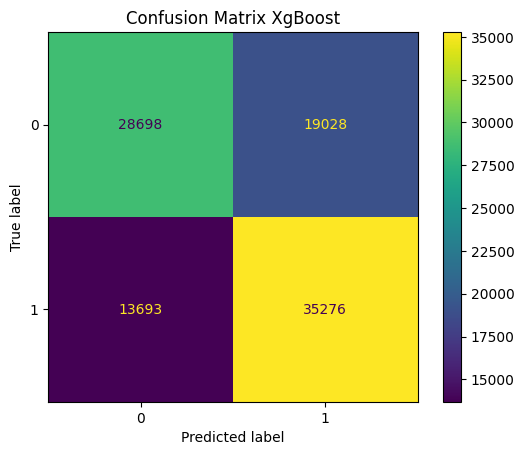

In [12]:

# param_dist = {
#     'max_depth': stats.randint(3, 10),
#     'learning_rate': stats.uniform(0.01, 0.1),
#     'subsample': stats.uniform(0.5, 0.5),
#     'n_estimators':stats.randint(50, 200)
# }

# 
# xgb_model = xgb.XGBClassifier()

# 
# random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, cv=2, scoring='accuracy')

# # Fit the RandomizedSearchCV object to the training data
# random_search.fit(X_train_selected, y_train)

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Best set of hyperparameters:  {'learning_rate': 0.05513443026230174, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.9720467798762586}
# Best score:  0.6240147885486791

# The accuracy in Train And Test is almost Similar showing 
# Xgb is learning only the revelant features so it's train and test are similar
params = {'learning_rate': 0.05513443026230174, 'max_depth': 6, 'n_estimators': 171, 'subsample': 0.9720467798762586}
xg = xgb.XGBClassifier(**params,random_state=0)
xg.fit(X_train_scaled,y_train)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, xg.predict(X_train_scaled)), display_labels=xg.classes_)
disp.plot(cmap="viridis")  
plt.title("Confusion Matrix XgBoost")

feature_importances = xg.feature_importances_
feature_names = X_train.columns 

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 5 features
top_5_features_xg = importance_df['Feature'].head(5).tolist()
print("Top 5 Features:", top_5_features_xg)

xg.score(X_train_scaled,y_train) # .63510 In Test

**Stacking Classifier**

[LightGBM] [Info] Number of positive: 48969, number of negative: 47726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5405
[LightGBM] [Info] Number of data points in the train set: 96695, number of used features: 268
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 24484, number of negative: 23863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5122
[LightGBM] [Info] Number of data points in the train set: 48347, number of used features: 237
[LightGBM] [Info

0.6867780133409174

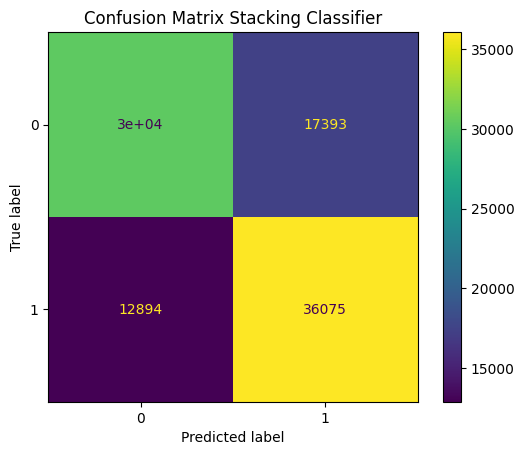

In [13]:
# Perform PCA to retain 98% variance
# Increased Score in CV but Test Score was lower So commenting out
# pca = PCA(n_components=0.98)
# X_train_scaled = pca.fit_transform(X_train_scaled)
# X_test_scaled = pca.transform(X_test_scaled)

# top_5_features = top_5_features_xg + top_5_features_lgbm
# # Lead to Kernel Freezes Due to large Data, Selecting Subsets lead to poorer scores 
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)  

# # # Assuming X is your input feature matrix
# X_train_pca = poly.fit_transform(X_train_scaled[top_5_features])
# X_test_pca = poly.fit_transform(X_test_scaled[top_5_features])

# My Final Estimator is a Stacking Classifier of the previous estimators
# Logistic Regression is used to select between LGBM And XG due to it's simplicity


# final_estimator = LogisticRegression(random_state=0)

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }

# # Perform GridSearchCV on the StackingClassifier
# grid_search = GridSearchCV(
#     estimator=final_estimator,
#     param_grid=param_grid,
#     cv=2,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )

# final_df = pd.DataFrame()
# final_df["xg"] = xg.predict(X_train_scaled)
# final_df["lgbm"] = lgbm.predict(X_train_scaled)
# grid_search.fit(final_df, y_train)

# # Display the best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# Fitting 2 folds for each of 16 candidates, totalling 32 fits
# Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
# Best Score: 0.7320130144848986

params = {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
final_estimator = LogisticRegression(random_state=0,**params)

model = StackingClassifier(
    estimators=[('lgbm', lgbm), ('xg', xg)],
    final_estimator=final_estimator,
    cv=2
)


model.fit(X_train_scaled,y_train)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, model.predict(X_train_scaled)), display_labels=model.classes_)
disp.plot(cmap="viridis")  
plt.title("Confusion Matrix Stacking Classifier")

model.score(X_train_scaled,y_train) #.6380 in Test, My highest Score for now

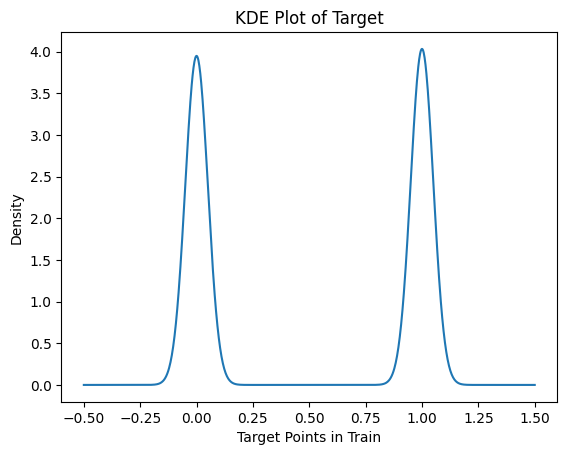

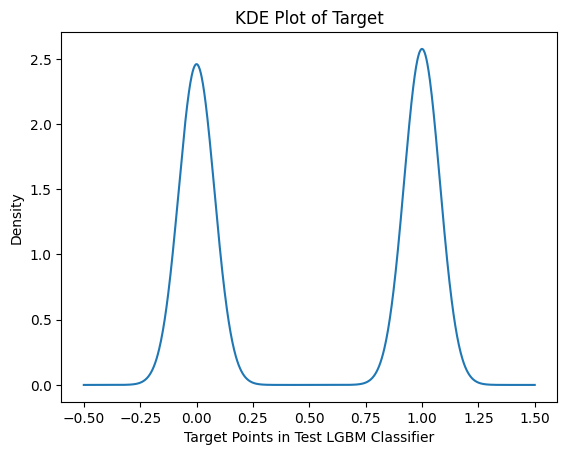

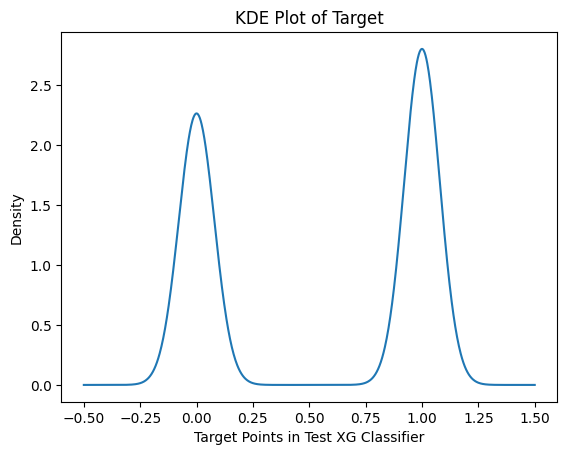

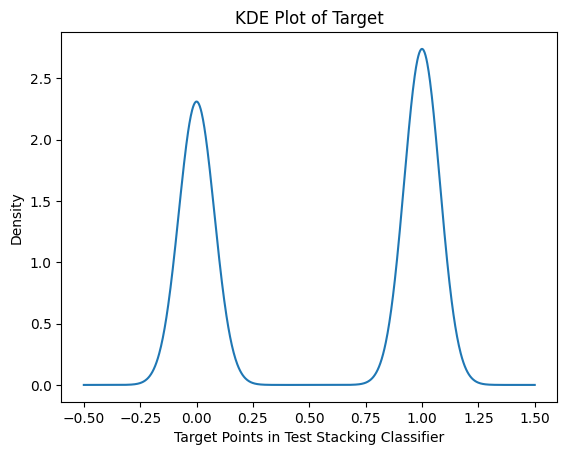

In [14]:
# Train is a balanced sample
# Hypothesis is that test is unbalanced and deviates significantly from the train distribution
# LightGBM tries being balanced and ends up worse in Test
# Xg is bit more unbalanced and is better
# Combining them inside a stacking classifier provided the best accuracy
# Test seems pretty unbalanced from these inferences

df['target'].plot(kind='kde', title='KDE Plot of Target')
plt.xlabel('Target Points in Train')
plt.show()

X_test_df['target'] =  lgbm.predict(X_test_scaled)
X_test_df['target'].plot(kind='kde', title='KDE Plot of Target')
plt.xlabel('Target Points in Test LGBM Classifier')
plt.show()

X_test_df['target'] =  xg.predict(X_test_scaled)
X_test_df['target'].plot(kind='kde', title='KDE Plot of Target')
plt.xlabel('Target Points in Test XG Classifier')
plt.show()

X_test_df['target'] =  model.predict(X_test_scaled)
X_test_df['target'].plot(kind='kde', title='KDE Plot of Target')
plt.xlabel('Target Points in Test Stacking Classifier')
plt.show()

# Submission

In [15]:
y_preds = model.predict(X_test_scaled)

In [16]:
submission = pd.read_csv("/kaggle/input/System-Threat-Forecaster/sample_submission.csv")
submission["target"] = y_preds

In [17]:
submission.to_csv("submission.csv",index=False)